# 2. Data preparation

In [18]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import networkx as nx
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import download
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk import ngrams
from nltk.tokenize import sent_tokenize
from collections import Counter
from itertools import chain

# Download NLTK data
download('stopwords')
download('punkt')
download('wordnet')
download('omw-1.4') 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Thy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Thy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Thy\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Thy\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [19]:
# Load comments
comments = pd.read_csv("./data/elon_comments.csv", sep = ",")
print(comments.shape)
comments.head()

(2873, 4)


,User,Comment,Time,Likes
0,@raedjah6417,NaN,4 years ago,4.6K
1,@jg63776,I like how he always says “we” . A real leader,4 years ago,171
2,@thatguynicky1979,Communism intensifies,4 years ago,101
3,@ibeezisi3847,"We, as in ALL of the geniuses and innovators h...",4 years ago,12
4,@leyren2606,Very good observation! I hope to imbibe that m...,4 years ago (edited),32


In [20]:
def clean_user(user_str):
    if type(user_str) != str:
        user_str = ""
    return re.sub("@", "", user_str)

In [21]:
def clean_time(time_str):
    # Remove "(edited)" and strip any extra spaces
    time_str = re.sub(r'\(edited\)', '', time_str).strip()
    
    # Turn youtube time formatting into a number of days
    if 'years' in time_str:
        num_years = int(re.search(r'\d+', time_str).group())
        days = num_years * 365
    elif 'months' in time_str:
        num_months = int(re.search(r'\d+', time_str).group())
        days = num_months * 30
    elif 'weeks' in time_str:
        num_weeks = int(re.search(r'\d+', time_str).group())
        days = num_weeks * 7
    elif 'days' in time_str:
        num_days = int(re.search(r'\d+', time_str).group())
        days = num_days
    elif 'year' in time_str:
        days = 365
    elif 'month' in time_str:
        days = 30
    elif 'hour' in time_str:
        days = 1
    else:
        raise ValueError(f"Unknown youtube date: {time_str}")
        
    return days

In [22]:
# Needed for "clean_likes"
def is_nan(value):
    if isinstance(value, (float)):
        return np.isnan(value)
    return False

In [23]:
def clean_likes(like_str):
    if is_nan(like_str):
            return 0
    if 'K' in like_str:
        return int(float(like_str.replace('K', '')) * 1000)
    else:
        return int(like_str)

In [24]:
def clean_yt_timestamp(time_str):
    return re.sub(r'\(edited\)', '', time_str).strip()

In [25]:
def clean_text(text):
    if type(text) != str:
        return ""
    
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation and special characters, as well as words with numbers in them
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    # Remove stop words and lemmatize
    cleaned_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    
    # Join tokens back to string
    cleaned_text = ' '.join(cleaned_tokens)
    
    return cleaned_text

In [26]:
def clean_data(comments): 
    # Apply cleaning functions
    comments["Comment"] = comments["Comment"].apply(clean_text)
    comments["n_days_ago"] = comments["Time"].apply(clean_time)
    comments["yt_timestamp"] = comments["Time"].apply(clean_yt_timestamp)
    comments.drop("Time", axis = 1, inplace = True)
    comments["Likes"] = comments["Likes"].apply(clean_likes)
    comments["User"] = comments["User"].apply(clean_user)

    return comments

In [27]:
# Show cleaned data
clean_comments = clean_data(comments)
clean_comments.head()

C:\Users\Thy\AppData\Local\Temp\ipykernel_7392\3905939949.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


,User,Comment,Likes,n_days_ago,yt_timestamp
0,raedjah6417,,4600,1460,4 years ago
1,jg63776,like always say “ ” real leader,171,1460,4 years ago
2,thatguynicky1979,communism intensifies,101,1460,4 years ago
3,ibeezisi3847,genius innovator employ,12,1460,4 years ago
4,leyren2606,good observation hope imbibe often,32,1460,4 years ago


# Clean comment text

In [28]:
def column_to_text(column):
    return ' '.join([comment for comment in list(column) if is_nan(comment) == False])

In [29]:
# Join all of the comments to a single text
comment_text = column_to_text(comments.Comment)

# Plot comments

### Unigram

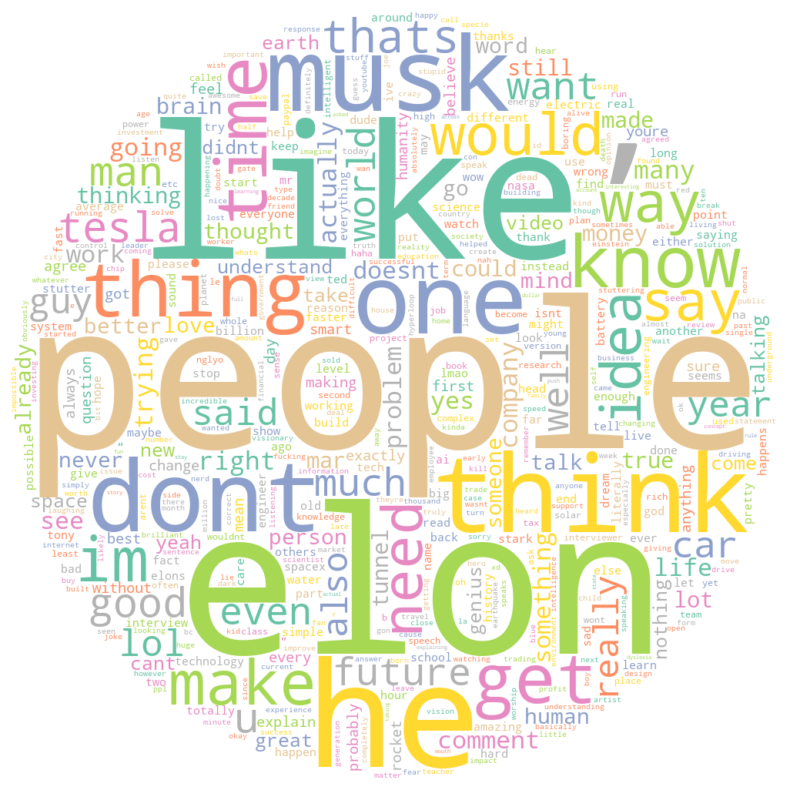

In [30]:
tokens = word_tokenize(comment_text)

# Calculate the frequency of each unigram
unigram_freq = Counter(tokens)

# Create a circular mask
def create_circle_mask(diameter):
    x, y = np.ogrid[:diameter, :diameter]
    center = (diameter - 1) / 2
    radius = diameter / 2
    mask = (x - center)**2 + (y - center)**2 > radius**2
    mask = 255 * mask.astype(int)
    return mask

# Define the diameter of the circle
diameter = 1000

# Create the mask
circle_mask = create_circle_mask(diameter)

# Generate a word cloud from the unigram frequencies with the circular mask
unigram_wordcloud = WordCloud(width=diameter, height=diameter, max_words=500, random_state=123, 
                              background_color='white', colormap='Set2', mask=circle_mask).generate_from_frequencies(unigram_freq)

# Function to plot the word cloud
def plot_cloud(wordcloud):
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Plot the unigram word cloud
plot_cloud(unigram_wordcloud)
